## Compare reconstruction to quad scan

In [21]:
import logging
from copy import deepcopy

import torch
from torchensemble import VotingRegressor

from modeling import Imager, InitialBeam, QuadScanTransport
from torch.utils.data import DataLoader, Dataset, random_split

logging.basicConfig(level=logging.INFO)
from image_processing import import_images

location = (
    "D:\\AWA\\phase_space_tomography_07_07_22" "\\Quadscan_data_matching_solenoid_180A"
)
base_fname = location + "\\DQ7_scan1_"

all_k, all_images, all_charges, xx = import_images()
all_charges = torch.tensor(all_charges)
all_images = torch.tensor(all_images)
all_k = torch.tensor(all_k)
print(all_images.shape)


# create data loader
class ImageDataset(Dataset):
    def __init__(self, k, images):
        self.images = images
        self.k = k

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.k[idx], self.images[idx]


def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        # torch.nn.init.xavier_uniform_(m.bias, gain=1.0)


class QuadScanModel(torch.nn.Module):
    def __init__(self, initial_beam, transport, imager):
        super(QuadScanModel, self).__init__()
        self.beam_generator = deepcopy(initial_beam)
        self.lattice = transport
        self.imager = imager

        self.beam_generator.apply(init_weights)

    def forward(self, K, custom_beam=None):
        initial_beam = self.beam_generator(custom_beam)
        output_beam = self.lattice(initial_beam, K)
        output_coords = torch.cat(
            [output_beam.x.unsqueeze(0), output_beam.y.unsqueeze(0)]
        )
        output_images = self.imager(output_coords)
        return output_images


defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(65.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

train_dset = torch.load("train.dset")
test_dset = torch.load("test.dset")

train_dataloader = DataLoader(train_dset, batch_size=2)
test_dataloader = DataLoader(test_dset)

# define model components and model
bins = xx[0].T[0]
bandwidth = torch.tensor(1.0e-2)

module_kwargs = {
    "initial_beam": InitialBeam(10000, n_hidden=4, width=100, **defaults),
    "transport": QuadScanTransport(),
    "imager": Imager(bins, bandwidth)
}

ensemble = VotingRegressor(
    estimator=QuadScanModel,
    estimator_args=module_kwargs,
    n_estimators=10,
    n_jobs=1
)


criterion = torch.nn.MSELoss(reduction="sum")
ensemble.set_criterion(criterion)

ensemble.set_optimizer(
    "Adam",
    lr=0.001
)

from torchensemble.utils import io
io.load(ensemble, ".")

for ele in ensemble:
    ele.imager.bandwidth = torch.tensor(1e-4)
print(ensemble[0].imager.bandwidth)

torch.Size([21, 10, 180, 180])
tensor(1.0000e-04)


In [22]:
def calc_rms_size(xx, images):
    # note image sums are normalized to 1
    xx_ = xx[0].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    yy_ = xx[1].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    proj_x = images.sum(dim=-1)
    proj_y = images.sum(dim=-2)
    
    x = xx_[...,:,0]
    y = yy_[...,0,:]
    
    mean_x = torch.sum(x * proj_x, dim=-1).unsqueeze(-1)
    mean_y = torch.sum(y * proj_y, dim=-1).unsqueeze(-1)
    
    var_x = torch.sum((x - mean_x)**2 * proj_x, dim=-1).unsqueeze(-1)
    var_y = torch.sum((y - mean_y)**2 * proj_y, dim=-1).unsqueeze(-1)
    
    # calculate cross covariance
    #var_xy = torch.sum((xx_ - mean_x)*(yy_ - mean_y)*images, dim=-1).unsqueeze(-1)

    return torch.cat([mean_x, mean_y], dim=-1), torch.cat([var_x, var_y], dim=-1)
    
means, variances = calc_rms_size(xx, all_images)

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [23]:
train_k = all_k[train_dset.indices]
train_k = train_k.cuda()

train_im = all_images[train_dset.indices]
train_im = train_im.cpu()

test_k = all_k[test_dset.indices]
test_k = test_k.cuda()

test_im = all_images[test_dset.indices]
test_im = test_im.cpu()
print(all_k.shape)

torch.Size([21, 10])


In [24]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = None#dist.sample([100000]).cuda()
    
        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda(), custom_beam).unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()
        
        torch.save(model_pred, "all_pred_images.pt")
    else:
        model_pred = torch.load("all_pred_images.pt")


In [25]:
print(model_pred.shape)


torch.Size([21, 10, 180, 180])


torch.Size([21, 10, 180, 180])
torch.Size([21, 10, 180, 180])


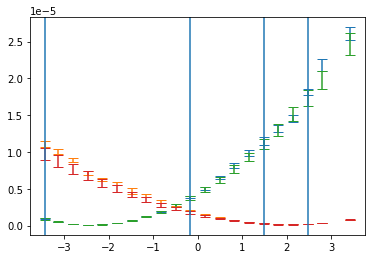

In [26]:
# plot quad scan
means, variances = calc_rms_size(xx, all_images)


fig,ax = plt.subplots()
k = all_k[:, 0]
mean_variance = torch.mean(variances, dim=-2)
error_variance = torch.std(variances, dim=-2)

ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='')
ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='')

print(model_pred.shape)
print(all_images.shape)
pmeans, pvariances = calc_rms_size(xx, model_pred)

mean_pvariance = torch.mean(pvariances, dim=-2)
error_pvariance = torch.std(pvariances, dim=-2)

#ax.plot(k, pvariances[...,0],'o')
#ax.plot(k, pvariances[...,1],'o')

ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='')
ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='')

for ele in test_dset.indices:
    ax.axvline(all_k[ele,0])

In [27]:
all_k[:,0]

tensor([-3.4185, -3.1302, -2.8007, -2.4712, -2.1417, -1.8122, -1.4827, -1.1532,
        -0.8237, -0.4942, -0.1647,  0.1647,  0.4942,  0.8237,  1.1532,  1.4827,
         1.8122,  2.1417,  2.4712,  2.8007,  3.4185], dtype=torch.float64)

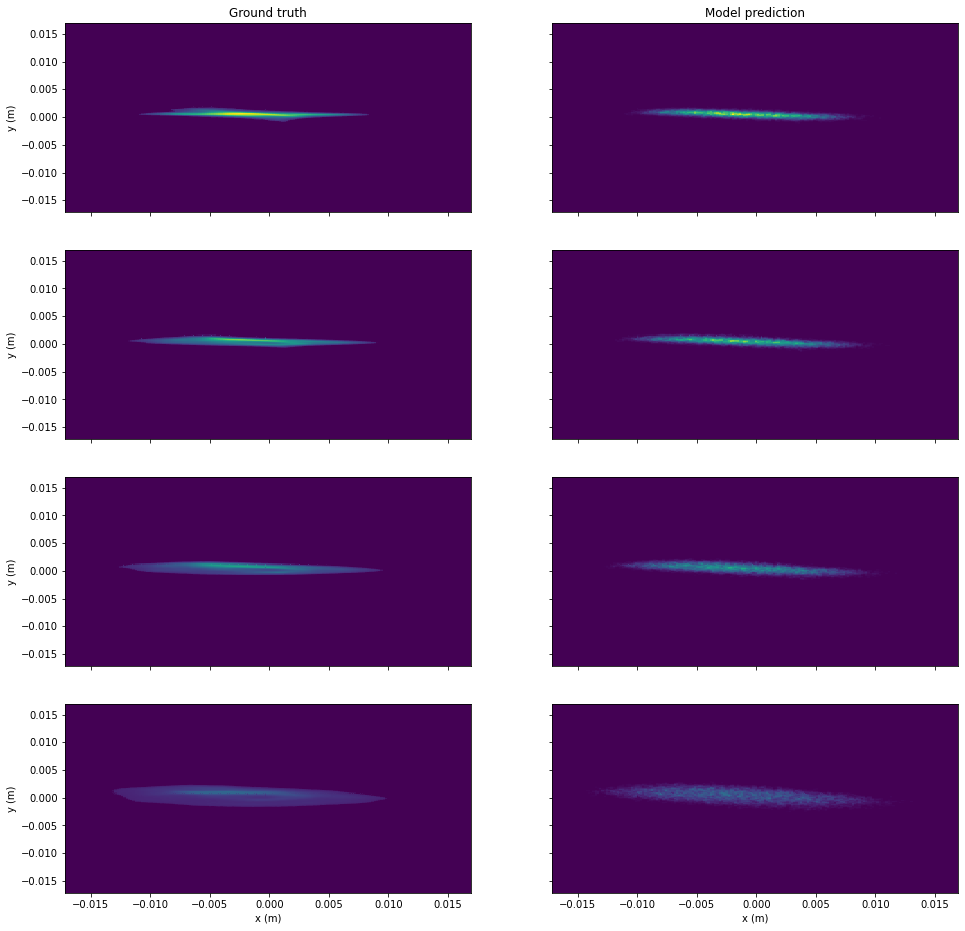

In [28]:
from visualization import compare_images
fig = compare_images(xx, model_pred[-4:,0], all_images[-4:,0])
#fig = compare_images(xx, model_pred[:6,0], all_images[:6,0])
fig.set_size_inches(16,16)

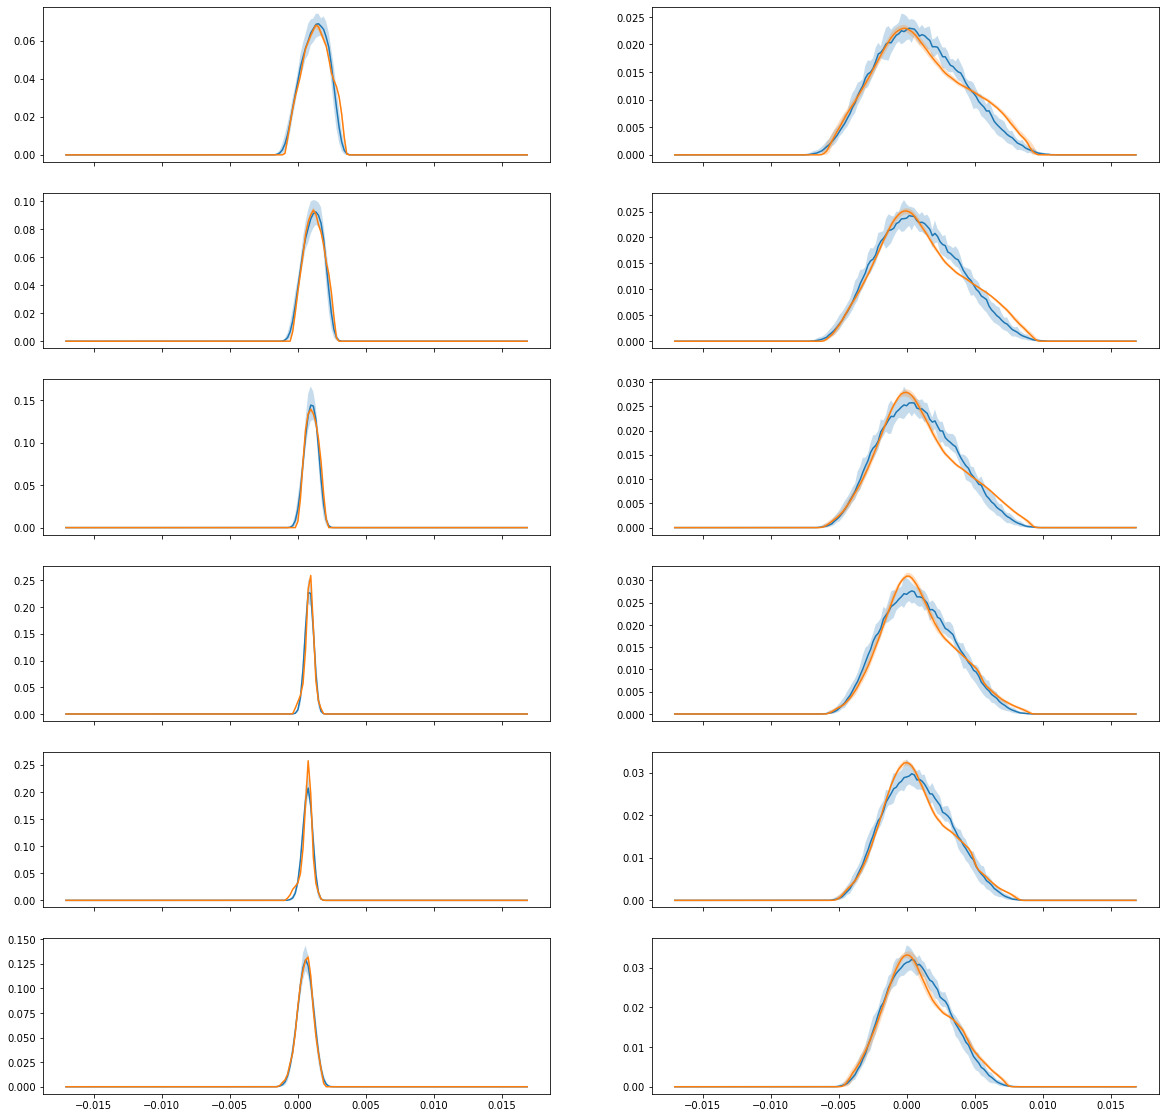

In [29]:
from visualization import compare_image_projections
fig = compare_image_projections(xx[0].T[0], model_pred[:6], all_images[:6])
fig.set_size_inches(20,20)

In [30]:
test_k[:,0]

tensor([-3.4185, -0.1647,  2.4712,  1.4827], device='cuda:0',
       dtype=torch.float64)